# term1 sprint4 機械学習スクラッチ：ロジスティック回帰

## 【問題1】仮定関数
ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。
ロジスティック回帰の仮定関数は、線形回帰の仮定関数を シグモイド関数 に通したものです。シグモイド関数は以下の式で表されます。
$$
g(z) = \frac{1}{1+e^{−z}}.
$$
線形回帰の仮定関数は次の式でした。
$$
h_\theta(x) = \theta^T \cdot x.
$$
まとめて書くと、ロジスティック回帰の仮定関数は次のようになります。
$$
h_\theta(x) = \frac{1}{1+e^{−\theta^T \cdot x}}.
$$
$x$ : 特徴量ベクトル
$\theta$ : パラメータ（重み）ベクトル

In [6]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue
    C : float
      正則化で使用するλ

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録
      
    self.theta : 次の形のndarray, shape (1, n_features)
      バイアスがTrueの時の0番目は切片の値、1番目以降は特徴量ごとの傾き
    self.M : int
      サンプル数
    self.error : 次の形のndarray, shape (n_samples, 1)
    self.val_flg : bool
      バリデーションデータがあるかどうか

    """
    def __init__(self, num_iter=5000, lr=0.001, no_bias=False, verbose=False, C=0.01, plot=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = no_bias
        self.verbose = verbose
        self.C = C
        self.plot = plot
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
    
    def _gradient_descent(self, X):
        """
        最急降下法でθから引く前の計算をする

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量

        Returns
        -------
            次の形のndarray, shape (1, n_features)
            最急降下法でθから引く前の計算結果

        """
        ramda = 0.01
        new_theta = self.theta.copy()
        new_theta[:, :1] = (self.error.T@X[:,:1])/X.shape[0]
        new_theta[:, 1:] = (self.error.T@X[:,1:])/X.shape[0] + ramda/self.M*self.theta[:, 1:]

        return new_theta * self.lr

    def crros_entropy(self, yp, yt, i):
        """
        交差エントロピー誤差
        """
        # 交差エントロピー誤差の計算
        loss = np.mean((-yt*np.log(yp) - (1 - yt)*np.log(1 - yp))/yp.shape[0])
        # 正則化項L2の計算
        start = 0
        if not self.no_bias:
            start = 1
        
        L2 = 0
        for j in range(start, self.theta.shape[1]):
            L2 += self.theta[0][j]**2
        
        L2 = L2 * self.C / (2 * yp.shape[0])
        loss += L2
        
        return loss
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # バイアスを入れる場合の処理
        if self.no_bias == False:
            X = np.concatenate([np.ones(X.shape[0]).reshape(X.shape[0], 1), X], axis=1)
            if X_val is not None:
                X_val = np.concatenate([np.ones(X_val.shape[0]).reshape(X_val.shape[0], 1), X_val], axis=1)
                
        # sample数をMとする
        self.M = X.shape[0]
        # 初回はθを1で作成
        self.theta = np.ones(X.shape[1]).reshape(1, X.shape[1])
        # yは行列に変形
        print(y.shape)
        
        
        for i in range(self.iter):
            #yp = 1/(1+np.exp(-1*self.theta @ X.T))
            yp = self.predict_proba(X)
            # 残差をerrorとする
            self.error = yp - y
            # パラメータの更新
            self.theta -= self._gradient_descent(X)
# 問題2の確認用ログはコメントアウト
#             print("new theta:", self._gradient_descent(X))
#             print("theta3:", self.theta)
#             break
            # lossを計算
            self.loss[i] = self.crros_entropy(yp, y, i)
            self.val_flg = False
            if X_val is not None and y_val is not None:
                self.val_flg = True
                yp_val = self.predict_proba(X_val)
                self.val_loss[i] = self.crros_entropy(yp_val, y_val, i)
            

            if self.verbose:
                #verboseをTrueにした際は学習過程を出力
                if i % 100 == 0:
                    print("predict_proba:", self.predict_proba(X))
                    print("predict:", self.predict(X))
                print("loss :", self.loss[i])
                
        self.predict(X)
        if  self.val_flg:
            self.predict(X_val)
            
        if self.plot:
            self.plot_func()
        
            

    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        
        p_proba = self.predict_proba(X)
        # 0.5より小さければ0、それ以外は1とする
        return np.where(p_proba < 0.5, 0, 1)
    
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        
         # self.no_bias==False:
        #外から呼ばれた場合でバイアスがある場合はXの先頭に１を入れる
        if not X.shape[1] == self.theta.shape[1]:
            X = np.concatenate([np.ones(X.shape[0]).reshape(X.shape[0], 1), X], axis=1)
            
        return 1/(1+np.exp(-1*X @ self.theta.T))
    
    def plot_func(self):
        print("loss:",self.loss)
        print("val loss:",self.val_loss)
        plt.title("loss function")
        plt.xlabel("iter")
        plt.ylabel("loss")
        plt.plot(self.loss, c="b")
        
        if  self.val_flg:
            plt.plot(self.val_loss, c="r")
        plt.show()
        

In [174]:
# sampleデータ
X = np.array([[5, 3.2], [5, 3.5], [5, 2.3], [5.5, 2.3], [6.1, 3.0]])
# ダミー変数1の列を入れる
X = np.concatenate([np.ones(X.shape[0]).reshape(X.shape[0], 1), X], axis=1)
y = np.array([0, 0, 1, 1, 1])
print(X)

[[1.  5.  3.2]
 [1.  5.  3.5]
 [1.  5.  2.3]
 [1.  5.5 2.3]
 [1.  6.1 3. ]]


In [186]:
w = np.ones(X.shape[1]).reshape(1, X.shape[1])
w

array([[1., 1., 1.]])

In [187]:
1 + np.exp(-1*w @ X.T)

array([[1.00010104, 1.00007485, 1.00024852, 1.00015073, 1.00004108]])

In [188]:
yp = 1/(1+np.exp(-1*w @ X.T))
yp

array([[0.99989897, 0.99992515, 0.99975154, 0.99984929, 0.99995892]])

## 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fit
メソッドから呼び出すようにしてください。
$$
\theta_j := \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j}\\ \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)}  ,j = 0\\ \frac{\partial J(\theta)}{\partial \theta_j} = \biggl(\frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)} \biggr) + \frac{λ}{m}\theta_j　 ,j\geq 1
$$
$\alpha$ : 学習率


$i$ : サンプルのインデックス


$j$ : 特徴量のインデックス


$m$ : 入力されるデータの数


$h_\theta()$ : 仮定関数


$x$ : 特徴量ベクトル


$\theta$ : パラメータ（重み）ベクトル


$x^{(i)}$ : i番目のサンプルの特徴量ベクトル


$y^{(i)}$ : i番目のサンプルの正解ラベル


$\theta_j$ : j番目のパラメータ（重み）


$λ$ : 正則化パラメータ

In [189]:
print("yp:",yp)
print("y:",y)

yp: [[0.99989897 0.99992515 0.99975154 0.99984929 0.99995892]]
y: [0 0 1 1 1]


In [190]:
error = yp - y
error.shape
#X.shape

(1, 5)

In [191]:
w = np.ones(X.shape[1]).reshape(1, X.shape[1])
M = X.shape[0]
ramda = 0.01
new_theta = w.copy()
print(new_theta)
new_theta[:, :1] = ((error@X[:,:1])/M)
new_theta[:, 1:] = (error@X[:,1:])/M + ramda/M*w[:, 1:]
print(new_theta)

[[1. 1. 1.]]
[[0.39987678 2.00135977 1.34167469]]


In [192]:
rl = 0.001
new_theta = rl * new_theta
print("new_theta", new_theta)
print("w", w)
w -= new_theta
w

new_theta [[0.00039988 0.00200136 0.00134167]]
w [[1. 1. 1.]]


array([[0.99960012, 0.99799864, 0.99865833]])

In [195]:
testSLR = ScratchLogisticRegression(no_bias=True)

In [196]:
testSLR.fit(X, y)

X [[1.  5.  3.2]
 [1.  5.  3.5]
 [1.  5.  2.3]
 [1.  5.5 2.3]
 [1.  6.1 3. ]]
X.shape (5, 3)
theta 0 [[1. 1. 1.]]
theta 1 [[1. 1. 1.]]
theta 2 [[1. 1. 1.]]
theta 1 [[0.99960012 0.99799864 0.99865833]]
theta 2 [[0.99960012 0.99799864 0.99865833]]
new theta: [[0.00039988 0.00200136 0.00134167]]
theta3: [[0.99960012 0.99799864 0.99865833]]


クラスでの実装と結果が同じとなった

## 【問題3】推定
推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。<br>
仮定関数 $h_\theta(x)$ の出力がpredict_probaの返り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの返り値となります。



サンプルデータ（Xにダミー変数の列を追加した物）で動くように実装しましたが、その後の問題の対応でサンプルはイレギュラーな形なので動かなくなりました
後半の問題の出力でご判断ください

In [175]:
test3_SLR = ScratchLogisticRegression(no_bias=True, verbose=True)

In [177]:
#test3_SLR.fit(X, y)

## 【問題4】目的関数
以下の数式で表されるロジスティック回帰の 目的関数（損失関数） を実装してください。<br>
そして、これをself.loss, self.val_lossに記録するようにしてください。<br>
なお、この数式には正則化項が含まれています。<br>
$$
J(\theta)=  \frac{1}{m}  \sum_{i=1}^{m}[−y^{(i)} log(h_θ(x^{(i)})) − (1−y^{(i)}) log(1−h_θ(x^{(i)}))] +
\frac{λ}{2m}\sum_{j=1}^n
θ^2_j.\\
$$
$m$ : 入力されるデータの数


$h_\theta()$ : 仮定関数


$x$ : 特徴量ベクトル


$\theta$ : パラメータ（重み）ベクトル


$x^{(i)}$ : i番目のサンプルの特徴量ベクトル


$y^{(i)}$ : i番目のサンプルの正解ラベル


$\theta_j$ : j番目のパラメータ（重み）


$n$ : 特徴量の数


$λ$ : 正則化パラメータ<br>
【補足】シグマは、総和の数が決まっている場合は一般的には1から始まり<br>
要素の数が不明なインデックスの最初は0で表す（問2のj=0）のではないか？

In [265]:
test4_SLR = ScratchLogisticRegression(no_bias=True, verbose=True)
test4_SLR.fit(X, y)

predict_proba: [[0.99989747 0.99992401 0.99974817 0.99984709 0.99995823]]
predict: [[1 1 1 1 1]]
loss : 0.7500179665248953
predict_proba: [[0.99989596 0.99992286 0.99974475 0.99984486 0.99995753]]
predict: [[1 1 1 1 1]]
loss : 0.7488195510143706
predict_proba: [[0.99989442 0.99992168 0.99974128 0.99984259 0.99995682]]
predict: [[1 1 1 1 1]]
loss : 0.7476211597519589
predict_proba: [[0.99989285 0.99992049 0.99973777 0.9998403  0.9999561 ]]
predict: [[1 1 1 1 1]]
loss : 0.746422792887331
predict_proba: [[0.99989127 0.99991928 0.99973421 0.99983796 0.99995536]]
predict: [[1 1 1 1 1]]
loss : 0.7452244505720599
predict_proba: [[0.99988966 0.99991806 0.9997306  0.9998356  0.99995461]]
predict: [[1 1 1 1 1]]
loss : 0.7440261329602137
predict_proba: [[0.99988802 0.99991681 0.99972694 0.9998332  0.99995385]]
predict: [[1 1 1 1 1]]
loss : 0.7428278402078581
predict_proba: [[0.99988636 0.99991554 0.99972323 0.99983077 0.99995308]]
predict: [[1 1 1 1 1]]
loss : 0.7416295724734351
predict_proba: [[

predict: [[1 1 1 1 1]]
loss : 0.5053801727328465
predict_proba: [[0.99789736 0.9983065  0.99597836 0.99699745 0.99872441]]
predict: [[1 1 1 1 1]]
loss : 0.5041975659269302
predict_proba: [[0.99786647 0.99828093 0.99592429 0.99695402 0.99870317]]
predict: [[1 1 1 1 1]]
loss : 0.5030151711132281
predict_proba: [[0.99783514 0.99825497 0.99586949 0.99690996 0.99868158]]
predict: [[1 1 1 1 1]]
loss : 0.5018329911421403
predict_proba: [[0.99780335 0.99822863 0.99581397 0.99686528 0.99865964]]
predict: [[1 1 1 1 1]]
loss : 0.5006510289043217
predict_proba: [[0.9977711  0.99820189 0.99575771 0.99681995 0.99863733]]
predict: [[1 1 1 1 1]]
loss : 0.49946928733119506
predict_proba: [[0.99773838 0.99817475 0.99570071 0.99677398 0.99861466]]
predict: [[1 1 1 1 1]]
loss : 0.49828776939553115
predict_proba: [[0.99770518 0.99814721 0.99564294 0.99672735 0.99859161]]
predict: [[1 1 1 1 1]]
loss : 0.4971064781119849
predict_proba: [[0.9976715  0.99811925 0.99558441 0.99668005 0.99856818]]
predict: [[1 1

predict_proba: [[0.97771307 0.98078296 0.96535034 0.96948777 0.98146683]]
predict: [[1 1 1 1 1]]
loss : 0.31500122323170954
predict_proba: [[0.97741067 0.98051408 0.96492498 0.96908361 0.98118116]]
predict: [[1 1 1 1 1]]
loss : 0.313948181951825
predict_proba: [[0.97710453 0.98024177 0.96449498 0.96867463 0.98089144]]
predict: [[1 1 1 1 1]]
loss : 0.3128970014595084
predict_proba: [[0.97679462 0.97996597 0.96406031 0.96826081 0.98059761]]
predict: [[1 1 1 1 1]]
loss : 0.3118477028854467
predict_proba: [[0.9764809  0.97968667 0.96362093 0.9678421  0.98029964]]
predict: [[1 1 1 1 1]]
loss : 0.3108003075191637
predict_proba: [[0.97616335 0.97940381 0.96317681 0.96741845 0.97999747]]
predict: [[1 1 1 1 1]]
loss : 0.30975483680795374
predict_proba: [[0.97584192 0.97911737 0.9627279  0.96698983 0.97969105]]
predict: [[1 1 1 1 1]]
loss : 0.3087113123557375
predict_proba: [[0.97551658 0.97882731 0.96227418 0.96655618 0.97938035]]
predict: [[1 1 1 1 1]]
loss : 0.3076697559218479
predict_proba: 

predict_proba: [[0.82489427 0.83714573 0.78381419 0.78086788 0.81055414]]
predict: [[1 1 1 1 1]]
loss : 0.17074427627140681
predict_proba: [[0.82378835 0.8360689  0.78263982 0.77959837 0.809238  ]]
predict: [[1 1 1 1 1]]
loss : 0.17041482182303289
predict_proba: [[0.82268333 0.83499252 0.78146781 0.77833118 0.80792267]]
predict: [[1 1 1 1 1]]
loss : 0.1700890367530554
predict_proba: [[0.8215793  0.83391668 0.78029823 0.77706638 0.80660825]]
predict: [[1 1 1 1 1]]
loss : 0.1697668958238217
predict_proba: [[0.82047633 0.83284145 0.77913117 0.77580408 0.80529484]]
predict: [[1 1 1 1 1]]
loss : 0.1694483736049084
predict_proba: [[0.81937451 0.83176692 0.77796668 0.77454434 0.80398255]]
predict: [[1 1 1 1 1]]
loss : 0.16913344448151652
predict_proba: [[0.81827389 0.83069315 0.77680485 0.77328727 0.80267148]]
predict: [[1 1 1 1 1]]
loss : 0.16882208266284415
predict_proba: [[0.81717458 0.82962023 0.77564574 0.77203293 0.80136174]]
predict: [[1 1 1 1 1]]
loss : 0.16851426219043047
predict_pro

predict_proba: [[0.67413909 0.68631428 0.63622832 0.62129848 0.63388449]]
predict: [[1 1 1 1 1]]
loss : 0.14666721418200032
predict_proba: [[0.67373483 0.6858954  0.63587559 0.62092423 0.63343973]]
predict: [[1 1 1 1 1]]
loss : 0.14663822107450716
predict_proba: [[0.67333356 0.68547948 0.63552589 0.62055331 0.63299865]]
predict: [[1 1 1 1 1]]
loss : 0.14660951398150854
predict_proba: [[0.67293525 0.68506648 0.6351792  0.6201857  0.63256125]]
predict: [[1 1 1 1 1]]
loss : 0.14658108821499363
predict_proba: [[0.67253989 0.6846564  0.6348355  0.61982138 0.63212748]]
predict: [[1 1 1 1 1]]
loss : 0.14655293916002737
predict_proba: [[0.67214746 0.68424921 0.63449476 0.61946032 0.63169732]]
predict: [[1 1 1 1 1]]
loss : 0.14652506227372894
predict_proba: [[0.67175793 0.6838449  0.63415697 0.61910251 0.63127076]]
predict: [[1 1 1 1 1]]
loss : 0.1464974530842625
predict_proba: [[0.67137129 0.68344345 0.63382209 0.61874791 0.63084776]]
predict: [[1 1 1 1 1]]
loss : 0.14647010718983755
predict_p

predict_proba: [[0.63304253 0.64228403 0.60474905 0.58921091 0.59303608]]
predict: [[1 1 1 1 1]]
loss : 0.1434444776242584
predict_proba: [[0.6329408  0.64216686 0.60469602 0.58916551 0.59296018]]
predict: [[1 1 1 1 1]]
loss : 0.14343190709923023
predict_proba: [[0.63283973 0.64205036 0.60464363 0.5891208  0.59288507]]
predict: [[1 1 1 1 1]]
loss : 0.1434193486589745
predict_proba: [[0.63273932 0.64193453 0.60459188 0.5890768  0.59281075]]
predict: [[1 1 1 1 1]]
loss : 0.143406802116383
predict_proba: [[0.63263957 0.64181935 0.60454076 0.58903348 0.59273722]]
predict: [[1 1 1 1 1]]
loss : 0.1433942672876344
predict_proba: [[0.63254046 0.64170482 0.60449026 0.58899085 0.59266446]]
predict: [[1 1 1 1 1]]
loss : 0.14338174399213696
predict_proba: [[0.632442   0.64159095 0.60444039 0.58894889 0.59259248]]
predict: [[1 1 1 1 1]]
loss : 0.14336923205247232
predict_proba: [[0.63234417 0.64147771 0.60439113 0.5889076  0.59252125]]
predict: [[1 1 1 1 1]]
loss : 0.1433567312943404
predict_proba:

loss : 0.1414102173483047
predict_proba: [[0.62194941 0.62861252 0.60169095 0.58798762 0.58753214]]
predict: [[1 1 1 1 1]]
loss : 0.14139846785200347
predict_proba: [[0.62190679 0.62855492 0.60169454 0.58800388 0.58752661]]
predict: [[1 1 1 1 1]]
loss : 0.14138672036020772
predict_proba: [[0.62186431 0.62849748 0.60169826 0.58802031 0.58752125]]
predict: [[1 1 1 1 1]]
loss : 0.14137497486372264
predict_proba: [[0.62182199 0.62844018 0.60170213 0.58803688 0.58751607]]
predict: [[1 1 1 1 1]]
loss : 0.1413632313535151
predict_proba: [[0.6217798  0.62838304 0.60170613 0.5880536  0.58751106]]
predict: [[1 1 1 1 1]]
loss : 0.1413514898207107
predict_proba: [[0.62173777 0.62832604 0.60171027 0.58807047 0.58750622]]
predict: [[1 1 1 1 1]]
loss : 0.14133975025659112
predict_proba: [[0.62169588 0.62826919 0.60171454 0.58808748 0.58750154]]
predict: [[1 1 1 1 1]]
loss : 0.14132801265259098
predict_proba: [[0.62165413 0.62821248 0.60171895 0.58810465 0.58749704]]
predict: [[1 1 1 1 1]]
loss : 0.14

predict_proba: [[0.61565109 0.61956183 0.60383063 0.59258795 0.58835742]]
predict: [[1 1 1 1 1]]
loss : 0.13925417245892668
predict_proba: [[0.61562215 0.61951807 0.60384685 0.59261778 0.58836774]]
predict: [[1 1 1 1 1]]
loss : 0.13924272643664262
predict_proba: [[0.61559324 0.61947434 0.60386309 0.59264762 0.58837809]]
predict: [[1 1 1 1 1]]
loss : 0.13923128190258308
predict_proba: [[0.61556436 0.61943064 0.60387935 0.5926775  0.58838847]]
predict: [[1 1 1 1 1]]
loss : 0.1392198388562765
predict_proba: [[0.61553551 0.61938697 0.60389564 0.5927074  0.58839888]]
predict: [[1 1 1 1 1]]
loss : 0.139208397297257
predict_proba: [[0.61550669 0.61934333 0.60391195 0.59273733 0.58840933]]
predict: [[1 1 1 1 1]]
loss : 0.13919695722506426
predict_proba: [[0.6154779  0.61929972 0.60392829 0.59276728 0.58841981]]
predict: [[1 1 1 1 1]]
loss : 0.1391855186392432
predict_proba: [[0.61544913 0.61925613 0.60394466 0.59279726 0.58843032]]
predict: [[1 1 1 1 1]]
loss : 0.13917408153934405
predict_prob

predict_proba: [[0.61020357 0.61113931 0.60739152 0.59888665 0.590824  ]]
predict: [[1 1 1 1 1]]
loss : 0.1369830133344825
predict_proba: [[0.61017757 0.61109852 0.60741004 0.59891873 0.59083736]]
predict: [[1 1 1 1 1]]
loss : 0.13697186064844774
predict_proba: [[0.61015158 0.61105774 0.60742856 0.59895082 0.59085072]]
predict: [[1 1 1 1 1]]
loss : 0.13696070940107752
predict_proba: [[0.61012559 0.61101696 0.60744709 0.59898291 0.59086409]]
predict: [[1 1 1 1 1]]
loss : 0.13694955959219923
predict_proba: [[0.61009961 0.61097619 0.60746561 0.59901501 0.59087746]]
predict: [[1 1 1 1 1]]
loss : 0.1369384112216404
predict_proba: [[0.61007363 0.61093543 0.60748415 0.5990471  0.59089084]]
predict: [[1 1 1 1 1]]
loss : 0.13692726428922858
predict_proba: [[0.61004766 0.61089467 0.60750268 0.5990792  0.59090422]]
predict: [[1 1 1 1 1]]
loss : 0.1369161187947915
predict_proba: [[0.6100217  0.61085392 0.60752122 0.5991113  0.5909176 ]]
predict: [[1 1 1 1 1]]
loss : 0.1369049747381571
predict_prob

predict: [[1 1 1 1 1]]
loss : 0.1351512431903613
predict_proba: [[0.60592493 0.6043922  0.61051053 0.6042565  0.59309949]]
predict: [[1 1 1 1 1]]
loss : 0.1351403270126728
predict_proba: [[0.6058996  0.60435209 0.61052928 0.60428862 0.59311327]]
predict: [[1 1 1 1 1]]
loss : 0.13512941224581962
predict_proba: [[0.60587427 0.60431198 0.61054802 0.60432075 0.59312706]]
predict: [[1 1 1 1 1]]
loss : 0.1351184988896362
predict_proba: [[0.60584894 0.60427188 0.61056677 0.60435287 0.59314084]]
predict: [[1 1 1 1 1]]
loss : 0.13510758694395666
predict_proba: [[0.60582361 0.60423179 0.61058552 0.60438499 0.59315463]]
predict: [[1 1 1 1 1]]
loss : 0.13509667640861556
predict_proba: [[0.60579829 0.60419169 0.61060426 0.60441711 0.59316842]]
predict: [[1 1 1 1 1]]
loss : 0.13508576728344712
predict_proba: [[0.60577297 0.6041516  0.61062301 0.60444923 0.59318221]]
predict: [[1 1 1 1 1]]
loss : 0.13507485956828577
predict_proba: [[0.60574765 0.60411151 0.61064176 0.60448135 0.593196  ]]
predict: [[

predict_proba: [[0.60130159 0.59705264 0.61395495 0.61014097 0.59564418]]
predict: [[1 1 1 1 1]]
loss : 0.1331555910113605
predict_proba: [[0.60127665 0.59701295 0.61397362 0.61017278 0.59565802]]
predict: [[1 1 1 1 1]]
loss : 0.13314493302436264
predict_proba: [[0.60125171 0.59697326 0.61399228 0.61020459 0.59567187]]
predict: [[1 1 1 1 1]]
loss : 0.13313427641764228
predict_proba: [[0.60122677 0.59693357 0.61401095 0.61023639 0.59568572]]
predict: [[1 1 1 1 1]]
loss : 0.13312362119103469
predict_proba: [[0.60120183 0.59689389 0.61402962 0.61026819 0.59569956]]
predict: [[1 1 1 1 1]]
loss : 0.13311296734437517
predict_proba: [[0.6011769  0.5968542  0.61404829 0.61029999 0.59571341]]
predict: [[1 1 1 1 1]]
loss : 0.1331023148774989
predict_proba: [[0.60115197 0.59681452 0.61406695 0.61033179 0.59572726]]
predict: [[1 1 1 1 1]]
loss : 0.13309166379024126
predict_proba: [[0.60112703 0.59677484 0.61408562 0.61036359 0.5957411 ]]
predict: [[1 1 1 1 1]]
loss : 0.13308101408243747
predict_pr

predict_proba: [[0.59637228 0.58919241 0.61765457 0.61642889 0.59839699]]
predict: [[1 1 1 1 1]]
loss : 0.13106163166036436
predict_proba: [[0.59634768 0.58915311 0.61767308 0.61646027 0.5984108 ]]
predict: [[1 1 1 1 1]]
loss : 0.13105124511005706
predict_proba: [[0.59632308 0.5891138  0.61769159 0.61649164 0.59842462]]
predict: [[1 1 1 1 1]]
loss : 0.13104085990735345
predict_proba: [[0.59629848 0.5890745  0.61771009 0.61652302 0.59843843]]
predict: [[1 1 1 1 1]]
loss : 0.13103047605208992
predict_proba: [[0.59627388 0.5890352  0.61772859 0.61655439 0.59845224]]
predict: [[1 1 1 1 1]]
loss : 0.13102009354410296
predict_proba: [[0.59624929 0.5889959  0.6177471  0.61658576 0.59846605]]
predict: [[1 1 1 1 1]]
loss : 0.13100971238322895
predict_proba: [[0.59622469 0.5889566  0.6177656  0.61661712 0.59847986]]
predict: [[1 1 1 1 1]]
loss : 0.13099933256930435
predict_proba: [[0.5962001  0.58891731 0.6177841  0.61664849 0.59849368]]
predict: [[1 1 1 1 1]]
loss : 0.13098895410216563
predict_

predict_proba: [[0.59184895 0.58195354 0.62106297 0.62219523 0.60094771]]
predict: [[1 1 1 1 1]]
loss : 0.12916288656176408
predict_proba: [[0.59182465 0.58191459 0.6210813  0.62222618 0.60096147]]
predict: [[1 1 1 1 1]]
loss : 0.12915274654122583
predict_proba: [[0.59180035 0.58187564 0.62109964 0.62225714 0.60097523]]
predict: [[1 1 1 1 1]]
loss : 0.12914260783814907
predict_proba: [[0.59177606 0.5818367  0.62111798 0.62228809 0.60098899]]
predict: [[1 1 1 1 1]]
loss : 0.1291324704523715
predict_proba: [[0.59175176 0.58179775 0.62113631 0.62231904 0.60100275]]
predict: [[1 1 1 1 1]]
loss : 0.12912233438373094
predict_proba: [[0.59172747 0.58175881 0.62115465 0.62234999 0.6010165 ]]
predict: [[1 1 1 1 1]]
loss : 0.12911219963206513
predict_proba: [[0.59170318 0.58171988 0.62117298 0.62238093 0.60103026]]
predict: [[1 1 1 1 1]]
loss : 0.1291020661972119
predict_proba: [[0.59167889 0.58168094 0.62119132 0.62241188 0.60104402]]
predict: [[1 1 1 1 1]]
loss : 0.12909193407900907
predict_pr

predict_proba: [[0.58745336 0.57489769 0.62438527 0.62779142 0.6034468 ]]
predict: [[1 1 1 1 1]]
loss : 0.12733894275511654
predict_proba: [[0.58742935 0.57485911 0.62440344 0.62782195 0.6034605 ]]
predict: [[1 1 1 1 1]]
loss : 0.12732903984836566
predict_proba: [[0.58740535 0.57482052 0.6244216  0.62785249 0.6034742 ]]
predict: [[1 1 1 1 1]]
loss : 0.127319138229684
predict_proba: [[0.58738135 0.57478194 0.62443977 0.62788302 0.6034879 ]]
predict: [[1 1 1 1 1]]
loss : 0.12730923789891085
predict_proba: [[0.58735735 0.57474337 0.62445794 0.62791355 0.6035016 ]]
predict: [[1 1 1 1 1]]
loss : 0.12729933885588554
predict_proba: [[0.58733336 0.57470479 0.6244761  0.62794408 0.6035153 ]]
predict: [[1 1 1 1 1]]
loss : 0.12728944110044738
predict_proba: [[0.58730936 0.57466621 0.62449426 0.6279746  0.603529  ]]
predict: [[1 1 1 1 1]]
loss : 0.12727954463243565
predict_proba: [[0.58728537 0.57462764 0.62451243 0.62800512 0.6035427 ]]
predict: [[1 1 1 1 1]]
loss : 0.1272696494516896
predict_pro

predict_proba: [[0.58360962 0.56871191 0.62729817 0.63267773 0.60564817]]
predict: [[1 1 1 1 1]]
loss : 0.12576105563352982
predict_proba: [[0.58358588 0.56867365 0.62731618 0.6327079  0.60566181]]
predict: [[1 1 1 1 1]]
loss : 0.1257513580421209
predict_proba: [[0.58356214 0.5686354  0.6273342  0.63273805 0.60567546]]
predict: [[1 1 1 1 1]]
loss : 0.12574166171302398
predict_proba: [[0.5835384  0.56859715 0.62735221 0.63276821 0.6056891 ]]
predict: [[1 1 1 1 1]]
loss : 0.1257319666460799
predict_proba: [[0.58351466 0.5685589  0.62737022 0.63279836 0.60570274]]
predict: [[1 1 1 1 1]]
loss : 0.12572227284112944
predict_proba: [[0.58349092 0.56852066 0.62738823 0.63282851 0.60571638]]
predict: [[1 1 1 1 1]]
loss : 0.12571258029801338
predict_proba: [[0.58346719 0.56848241 0.62740624 0.63285866 0.60573003]]
predict: [[1 1 1 1 1]]
loss : 0.1257028890165725
predict_proba: [[0.58344345 0.56844417 0.62742425 0.63288881 0.60574367]]
predict: [[1 1 1 1 1]]
loss : 0.12569319899664766
predict_pro

predict_proba: [[0.57983113 0.56261799 0.63016837 0.63747354 0.60782652]]
predict: [[1 1 1 1 1]]
loss : 0.12422539121158978
predict_proba: [[0.57980765 0.56258008 0.63018623 0.63750332 0.60784011]]
predict: [[1 1 1 1 1]]
loss : 0.12421589357145224
predict_proba: [[0.57978416 0.56254216 0.63020409 0.6375331  0.60785369]]
predict: [[1 1 1 1 1]]
loss : 0.12420639716827804
predict_proba: [[0.57976068 0.56250425 0.63022195 0.63756288 0.60786728]]
predict: [[1 1 1 1 1]]
loss : 0.12419690200190965
predict_proba: [[0.5797372  0.56246634 0.6302398  0.63759266 0.60788086]]
predict: [[1 1 1 1 1]]
loss : 0.12418740807218939
predict_proba: [[0.57971372 0.56242843 0.63025766 0.63762244 0.60789444]]
predict: [[1 1 1 1 1]]
loss : 0.12417791537895971
predict_proba: [[0.57969024 0.56239052 0.63027552 0.63765221 0.60790802]]
predict: [[1 1 1 1 1]]
loss : 0.12416842392206308
predict_proba: [[0.57966676 0.56235262 0.63029337 0.63768198 0.60792161]]
predict: [[1 1 1 1 1]]
loss : 0.12415893370134182
predict_

predict_proba: [[0.5750731  0.55492755 0.63379183 0.64350063 0.6105896 ]]
predict: [[1 1 1 1 1]]
loss : 0.12231326619144108
predict_proba: [[0.57504994 0.55489007 0.6338095  0.64352993 0.6106031 ]]
predict: [[1 1 1 1 1]]
loss : 0.12230401764323323
predict_proba: [[0.57502679 0.5548526  0.63382716 0.64355923 0.6106166 ]]
predict: [[1 1 1 1 1]]
loss : 0.12229477030005859
predict_proba: [[0.57500363 0.55481513 0.63384482 0.64358853 0.6106301 ]]
predict: [[1 1 1 1 1]]
loss : 0.12228552416176174
predict_proba: [[0.57498047 0.55477766 0.63386248 0.64361782 0.61064361]]
predict: [[1 1 1 1 1]]
loss : 0.12227627922818733
predict_proba: [[0.57495732 0.55474019 0.63388013 0.64364712 0.61065711]]
predict: [[1 1 1 1 1]]
loss : 0.12226703549917999
predict_proba: [[0.57493417 0.55470273 0.63389779 0.64367641 0.61067061]]
predict: [[1 1 1 1 1]]
loss : 0.12225779297458435
predict_proba: [[0.57491102 0.55466527 0.63391545 0.64370569 0.61068411]]
predict: [[1 1 1 1 1]]
loss : 0.12224855165424509
predict_

loss : 0.12075819867764472
predict_proba: [[0.5711359  0.54855124 0.63679768 0.64847676 0.61289265]]
predict: [[1 1 1 1 1]]
loss : 0.12074915276207816
predict_proba: [[0.57111301 0.54851414 0.63681517 0.64850566 0.61290608]]
predict: [[1 1 1 1 1]]
loss : 0.12074010802529339
predict_proba: [[0.57109012 0.54847704 0.63683267 0.64853455 0.61291951]]
predict: [[1 1 1 1 1]]
loss : 0.12073106446713686
predict_proba: [[0.57106724 0.54843995 0.63685016 0.64856344 0.61293294]]
predict: [[1 1 1 1 1]]
loss : 0.1207220220874551
predict_proba: [[0.57104435 0.54840286 0.63686765 0.64859233 0.61294637]]
predict: [[1 1 1 1 1]]
loss : 0.12071298088609488
predict_proba: [[0.57102147 0.54836577 0.63688514 0.64862122 0.6129598 ]]
predict: [[1 1 1 1 1]]
loss : 0.12070394086290274
predict_proba: [[0.57099859 0.54832868 0.63690262 0.6486501  0.61297323]]
predict: [[1 1 1 1 1]]
loss : 0.12069490201772522
predict_proba: [[0.57097571 0.5482916  0.63692011 0.64867898 0.61298666]]
predict: [[1 1 1 1 1]]
loss : 0.

predict: [[1 1 1 1 1]]
loss : 0.11926375328642178
predict_proba: [[0.56733553 0.54238706 0.63970524 0.65326936 0.61512977]]
predict: [[1 1 1 1 1]]
loss : 0.11925490211003303
predict_proba: [[0.56731291 0.54235033 0.63972257 0.65329786 0.61514313]]
predict: [[1 1 1 1 1]]
loss : 0.11924605208697264
predict_proba: [[0.56729028 0.54231361 0.63973989 0.65332636 0.61515649]]
predict: [[1 1 1 1 1]]
loss : 0.11923720321708912
predict_proba: [[0.56726766 0.5422769  0.63975722 0.65335485 0.61516984]]
predict: [[1 1 1 1 1]]
loss : 0.11922835550023116
predict_proba: [[0.56724504 0.54224018 0.63977454 0.65338334 0.6151832 ]]
predict: [[1 1 1 1 1]]
loss : 0.11921950893624739
predict_proba: [[0.56722243 0.54220347 0.63979186 0.65341183 0.61519656]]
predict: [[1 1 1 1 1]]
loss : 0.11921066352498644
predict_proba: [[0.56719981 0.54216676 0.63980919 0.65344032 0.61520992]]
predict: [[1 1 1 1 1]]
loss : 0.119201819266297
predict_proba: [[0.5671772  0.54213005 0.63982651 0.6534688  0.61522327]]
predict: [

predict_proba: [[0.56342259 0.53603183 0.64270504 0.65819215 0.61744747]]
predict: [[1 1 1 1 1]]
loss : 0.11773222440525598
predict_proba: [[0.56340024 0.53599551 0.64272219 0.65822023 0.61746076]]
predict: [[1 1 1 1 1]]
loss : 0.11772357276756312
predict_proba: [[0.56337789 0.53595919 0.64273934 0.65824832 0.61747403]]
predict: [[1 1 1 1 1]]
loss : 0.11771492225689885
predict_proba: [[0.56335555 0.53592287 0.64275649 0.65827639 0.61748731]]
predict: [[1 1 1 1 1]]
loss : 0.11770627287311403
predict_proba: [[0.5633332  0.53588655 0.64277364 0.65830447 0.61750059]]
predict: [[1 1 1 1 1]]
loss : 0.11769762461605951
predict_proba: [[0.56331086 0.53585024 0.64279079 0.65833254 0.61751387]]
predict: [[1 1 1 1 1]]
loss : 0.11768897748558614
predict_proba: [[0.56328851 0.53581393 0.64280794 0.65836061 0.61752715]]
predict: [[1 1 1 1 1]]
loss : 0.11768033148154484
predict_proba: [[0.56326617 0.53577762 0.64282509 0.65838868 0.61754043]]
predict: [[1 1 1 1 1]]
loss : 0.1176716866037865
predict_p

predict_proba: [[0.55931421 0.52935137 0.6458611  0.66334695 0.61989639]]
predict: [[1 1 1 1 1]]
loss : 0.116150699219011
predict_proba: [[0.55929215 0.52931548 0.64587806 0.66337459 0.61990958]]
predict: [[1 1 1 1 1]]
loss : 0.11614225355656078
predict_proba: [[0.55927009 0.52927959 0.64589503 0.66340223 0.61992277]]
predict: [[1 1 1 1 1]]
loss : 0.11613380899376873
predict_proba: [[0.55924803 0.5292437  0.64591199 0.66342987 0.61993597]]
predict: [[1 1 1 1 1]]
loss : 0.1161253655304882
predict_proba: [[0.55922597 0.52920781 0.64592895 0.6634575  0.61994916]]
predict: [[1 1 1 1 1]]
loss : 0.11611692316657247
predict_proba: [[0.55920391 0.52917192 0.64594592 0.66348514 0.61996235]]
predict: [[1 1 1 1 1]]
loss : 0.11610848190187485
predict_proba: [[0.55918186 0.52913604 0.64596288 0.66351277 0.61997554]]
predict: [[1 1 1 1 1]]
loss : 0.1161000417362487
predict_proba: [[0.5591598  0.52910016 0.64597984 0.66354039 0.61998873]]
predict: [[1 1 1 1 1]]
loss : 0.11609160266954731
predict_prob

predict_proba: [[0.55532424 0.52285724 0.64893221 0.66833854 0.62228966]]
predict: [[1 1 1 1 1]]
loss : 0.1146315567323231
predict_proba: [[0.55530246 0.52282177 0.64894899 0.66836575 0.62230277]]
predict: [[1 1 1 1 1]]
loss : 0.11462330880456639
predict_proba: [[0.55528068 0.52278631 0.64896577 0.66839296 0.62231587]]
predict: [[1 1 1 1 1]]
loss : 0.11461506194999004
predict_proba: [[0.5552589  0.52275085 0.64898255 0.66842016 0.62232898]]
predict: [[1 1 1 1 1]]
loss : 0.11460681616844987
predict_proba: [[0.55523712 0.52271539 0.64899933 0.66844736 0.62234208]]
predict: [[1 1 1 1 1]]
loss : 0.11459857145980157
predict_proba: [[0.55521535 0.52267993 0.64901611 0.66847456 0.62235518]]
predict: [[1 1 1 1 1]]
loss : 0.11459032782390102
predict_proba: [[0.55519357 0.52264448 0.64903289 0.66850176 0.62236829]]
predict: [[1 1 1 1 1]]
loss : 0.11458208526060405
predict_proba: [[0.5551718  0.52260902 0.64904966 0.66852895 0.62238139]]
predict: [[1 1 1 1 1]]
loss : 0.11457384376976638
predict_p

predict_proba: [[0.55185865 0.51721272 0.65160432 0.67266164 0.6243802 ]]
predict: [[1 1 1 1 1]]
loss : 0.11332544288990685
predict_proba: [[0.55183711 0.51717763 0.65162094 0.67268847 0.62439323]]
predict: [[1 1 1 1 1]]
loss : 0.11331736484575318
predict_proba: [[0.55181558 0.51714255 0.65163756 0.6727153  0.62440625]]
predict: [[1 1 1 1 1]]
loss : 0.11330928785188074
predict_proba: [[0.55179404 0.51710747 0.65165418 0.67274212 0.62441928]]
predict: [[1 1 1 1 1]]
loss : 0.11330121190814753
predict_proba: [[0.55177251 0.51707239 0.65167079 0.67276894 0.6244323 ]]
predict: [[1 1 1 1 1]]
loss : 0.11329313701441161
predict_proba: [[0.55175098 0.51703731 0.65168741 0.67279576 0.62444532]]
predict: [[1 1 1 1 1]]
loss : 0.11328506317053097
predict_proba: [[0.55172945 0.51700224 0.65170402 0.67282258 0.62445835]]
predict: [[1 1 1 1 1]]
loss : 0.11327699037636374
predict_proba: [[0.55170792 0.51696716 0.65172064 0.67284939 0.62447137]]
predict: [[1 1 1 1 1]]
loss : 0.11326891863176798
predict_

predict_proba: [[0.54828306 0.51138631 0.65436555 0.67710906 0.62654845]]
predict: [[1 1 1 1 1]]
loss : 0.11199085966179334
predict_proba: [[0.54826178 0.51135162 0.654382   0.6771355  0.62656139]]
predict: [[1 1 1 1 1]]
loss : 0.111982955057321
predict_proba: [[0.5482405  0.51131694 0.65439845 0.67716193 0.62657433]]
predict: [[1 1 1 1 1]]
loss : 0.11197505147961484
predict_proba: [[0.54821922 0.51128226 0.65441489 0.67718835 0.62658727]]
predict: [[1 1 1 1 1]]
loss : 0.1119671489285353
predict_proba: [[0.54819794 0.51124758 0.65443134 0.67721478 0.62660021]]
predict: [[1 1 1 1 1]]
loss : 0.11195924740394277
predict_proba: [[0.54817666 0.5112129  0.65444778 0.6772412  0.62661314]]
predict: [[1 1 1 1 1]]
loss : 0.11195134690569764
predict_proba: [[0.54815538 0.51117822 0.65446423 0.67726762 0.62662608]]
predict: [[1 1 1 1 1]]
loss : 0.11194344743366039
predict_proba: [[0.54813411 0.51114355 0.65448067 0.67729404 0.62663902]]
predict: [[1 1 1 1 1]]
loss : 0.11193554898769144
predict_pro

predict_proba: [[0.54502317 0.50607276 0.65688662 0.6811518  0.62853519]]
predict: [[1 1 1 1 1]]
loss : 0.11078556389933317
predict_proba: [[0.54500211 0.50603844 0.65690291 0.68117787 0.62854805]]
predict: [[1 1 1 1 1]]
loss : 0.11077781578077568
predict_proba: [[0.54498106 0.50600413 0.65691921 0.68120393 0.62856091]]
predict: [[1 1 1 1 1]]
loss : 0.1107700686676554
predict_proba: [[0.54496002 0.50596982 0.65693549 0.68123    0.62857377]]
predict: [[1 1 1 1 1]]
loss : 0.11076232255983497
predict_proba: [[0.54493897 0.50593551 0.65695178 0.68125606 0.62858663]]
predict: [[1 1 1 1 1]]
loss : 0.11075457745717698
predict_proba: [[0.54491792 0.5059012  0.65696807 0.68128212 0.62859949]]
predict: [[1 1 1 1 1]]
loss : 0.11074683335954412
predict_proba: [[0.54489688 0.50586689 0.65698436 0.68130818 0.62861234]]
predict: [[1 1 1 1 1]]
loss : 0.11073909026679905
predict_proba: [[0.54487584 0.50583259 0.65700064 0.68133423 0.6286252 ]]
predict: [[1 1 1 1 1]]
loss : 0.11073134817880444
predict_p

predict_proba: [[0.54181962 0.50085037 0.65936736 0.68511295 0.63049671]]
predict: [[1 1 1 1 1]]
loss : 0.10961171290316653
predict_proba: [[0.54179879 0.50081643 0.65938349 0.68513866 0.63050949]]
predict: [[1 1 1 1 1]]
loss : 0.10960411702768191
predict_proba: [[0.54177797 0.50078248 0.65939963 0.68516436 0.63052227]]
predict: [[1 1 1 1 1]]
loss : 0.10959652213678656
predict_proba: [[0.54175715 0.50074854 0.65941576 0.68519007 0.63053505]]
predict: [[1 1 1 1 1]]
loss : 0.10958892823034543
predict_proba: [[0.54173633 0.5007146  0.65943189 0.68521577 0.63054783]]
predict: [[1 1 1 1 1]]
loss : 0.10958133530822334
predict_proba: [[0.54171551 0.50068066 0.65944802 0.68524147 0.6305606 ]]
predict: [[1 1 1 1 1]]
loss : 0.10957374337028525
predict_proba: [[0.5416947  0.50064673 0.65946415 0.68526717 0.63057338]]
predict: [[1 1 1 1 1]]
loss : 0.10956615241639607
predict_proba: [[0.54167388 0.5006128  0.65948028 0.68529286 0.63058616]]
predict: [[1 1 1 1 1]]
loss : 0.10955856244642065
predict_

predict_proba: [[0.53825971 0.49504719 0.66212762 0.68950047 0.63268691]]
predict: [[1 0 1 1 1]]
loss : 0.108319589602562
predict_proba: [[0.53823914 0.49501366 0.66214358 0.68952578 0.63269959]]
predict: [[1 0 1 1 1]]
loss : 0.10831216110156108
predict_proba: [[0.53821858 0.49498013 0.66215954 0.68955108 0.63271228]]
predict: [[1 0 1 1 1]]
loss : 0.10830473356212499
predict_proba: [[0.53819801 0.49494661 0.6621755  0.68957638 0.63272497]]
predict: [[1 0 1 1 1]]
loss : 0.10829730698412116
predict_proba: [[0.53817744 0.49491309 0.66219145 0.68960168 0.63273765]]
predict: [[1 0 1 1 1]]
loss : 0.10828988136741705
predict_proba: [[0.53815688 0.49487957 0.66220741 0.68962698 0.63275034]]
predict: [[1 0 1 1 1]]
loss : 0.10828245671188007
predict_proba: [[0.53813632 0.49484605 0.66222336 0.68965227 0.63276302]]
predict: [[1 0 1 1 1]]
loss : 0.10827503301737772
predict_proba: [[0.53811576 0.49481254 0.66223932 0.68967757 0.6327757 ]]
predict: [[1 0 1 1 1]]
loss : 0.10826761028377743
predict_pr

predict_proba: [[0.53502788 0.48977974 0.66463661 0.69347008 0.6346847 ]]
predict: [[1 0 1 1 1]]
loss : 0.10715772759815523
predict_proba: [[0.53500754 0.4897466  0.66465241 0.69349502 0.6346973 ]]
predict: [[1 0 1 1 1]]
loss : 0.10715044938964137
predict_proba: [[0.5349872  0.48971346 0.66466821 0.69351996 0.6347099 ]]
predict: [[1 0 1 1 1]]
loss : 0.10714317212192996
predict_proba: [[0.53496686 0.48968032 0.664684   0.6935449  0.6347225 ]]
predict: [[1 0 1 1 1]]
loss : 0.10713589579489079
predict_proba: [[0.53494653 0.48964718 0.6646998  0.69356983 0.6347351 ]]
predict: [[1 0 1 1 1]]
loss : 0.10712862040839362
predict_proba: [[0.5349262  0.48961404 0.66471559 0.69359476 0.6347477 ]]
predict: [[1 0 1 1 1]]
loss : 0.10712134596230834
predict_proba: [[0.53490587 0.48958091 0.66473139 0.69361969 0.6347603 ]]
predict: [[1 0 1 1 1]]
loss : 0.10711407245650466
predict_proba: [[0.53488554 0.48954778 0.66474718 0.69364461 0.63477289]]
predict: [[1 0 1 1 1]]
loss : 0.1071067998908525
predict_p

predict_proba: [[0.53149067 0.48401655 0.66738587 0.69779933 0.63688142]]
predict: [[1 0 1 1 1]]
loss : 0.10589825106270552
predict_proba: [[0.53147059 0.48398383 0.66740149 0.69782387 0.63689392]]
predict: [[1 0 1 1 1]]
loss : 0.10589113552520643
predict_proba: [[0.5314505  0.48395111 0.66741711 0.6978484  0.63690643]]
predict: [[1 0 1 1 1]]
loss : 0.10588402090594994
predict_proba: [[0.53143042 0.4839184  0.66743273 0.69787293 0.63691893]]
predict: [[1 0 1 1 1]]
loss : 0.10587690720480841
predict_proba: [[0.53141034 0.48388569 0.66744835 0.69789746 0.63693143]]
predict: [[1 0 1 1 1]]
loss : 0.10586979442165435
predict_proba: [[0.53139026 0.48385298 0.66746396 0.69792199 0.63694393]]
predict: [[1 0 1 1 1]]
loss : 0.10586268255636012
predict_proba: [[0.53137018 0.48382028 0.66747958 0.69794651 0.63695643]]
predict: [[1 0 1 1 1]]
loss : 0.10585557160879823
predict_proba: [[0.5313501  0.48378757 0.66749519 0.69797103 0.63696893]]
predict: [[1 0 1 1 1]]
loss : 0.10584846157884112
predict_

## 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行なってください。<br>
scikit-learnによる実装と比べ、正しく動いているかを確認してください。<br>
AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [30]:
iris_data = datasets.load_iris()
input_data = iris_data.data
X = pd.DataFrame(data=input_data, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])
correct = iris_data.target
y = pd.DataFrame(data=correct, columns=["Species"])
df = pd.concat([X, y], axis=1)
df.drop(df.index[df["Species"]==0], inplace=True)

In [31]:
df["Species"] = df["Species"] - 1

In [32]:
df

,sepal_length,sepal_width,petal_length,petal_width,Species
50,7.0,3.2,4.7,1.4,0
51,6.4,3.2,4.5,1.5,0
52,6.9,3.1,4.9,1.5,0
53,5.5,2.3,4.0,1.3,0
54,6.5,2.8,4.6,1.5,0
55,5.7,2.8,4.5,1.3,0
56,6.3,3.3,4.7,1.6,0
57,4.9,2.4,3.3,1.0,0
58,6.6,2.9,4.6,1.3,0
59,5.2,2.7,3.9,1.4,0


In [33]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df.iloc[:, :-1].values, df.iloc[:, -1:].values, train_size=0.75, random_state=1, shuffle=True)

/Users/arisa/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [34]:
# 標準化
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)

In [35]:
y_train.shape

(75, 1)

In [36]:
# 学習と推定:ロジスティック回帰(勾配降下法を使用)
from sklearn.linear_model import SGDClassifier
sgdc_model = SGDClassifier(loss="log")
sgdc_model.fit(X_train_std, y_train)
y_val_pred = sgdc_model.predict(X_val_std)
y_val_pred

/Users/arisa/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/arisa/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0])

(75, 1)
loss: [0.00509315 0.0050926  0.00509205 ... 0.00340002 0.00339983 0.00339963]
val loss: [0.0206839  0.02068314 0.02068238 ... 0.01751596 0.01751544 0.01751493]


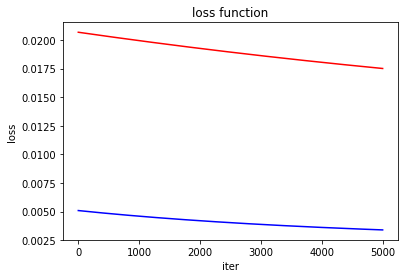

In [37]:
# スクラッチ
SLR = ScratchLogisticRegression(plot=True)
SLR.fit(X_train_std, y_train, X_val_std, y_val)

In [38]:
y_val_pred_sc = SLR.predict(X_val_std)
y_val_predproba_sc = SLR.predict_proba(X_val_std)

In [39]:
y_val_pred_sc.T

array([[1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 1, 0]])

In [40]:
# Accuracy(正解率)
from sklearn.metrics import accuracy_score
print("sklearnの正解率は{}です".format(accuracy_score(y_val, y_val_pred)))
print("スクラッチの正解率は{}です".format(accuracy_score(y_val, y_val_pred_sc)))
# Precision(適合率)
from sklearn.metrics import precision_score
print("sklearnの適合率は{}です".format(precision_score(y_val, y_val_pred)))
print("スクラッチの適合率は{}です".format(precision_score(y_val, y_val_pred_sc)))
# 混同行列
from sklearn.metrics import confusion_matrix
print("sklearnの混同行列は\n{}です".format(confusion_matrix(y_val, y_val_pred)))
print("スクラッチの混同行列は\n{}です".format(confusion_matrix(y_val, y_val_pred_sc)))

sklearnの正解率は0.84です
スクラッチの正解率は0.8です
sklearnの適合率は0.9230769230769231です
スクラッチの適合率は0.8571428571428571です
sklearnの混同行列は
[[ 9  1]
 [ 3 12]]です
スクラッチの混同行列は
[[ 8  2]
 [ 3 12]]です


(75, 1)
loss: [0.00509315 0.0050926  0.00509205 ... 0.00275031 0.00275023 0.00275015]
val loss: [0.0206839  0.02068314 0.02068238 ... 0.01541246 0.01541212 0.01541178]


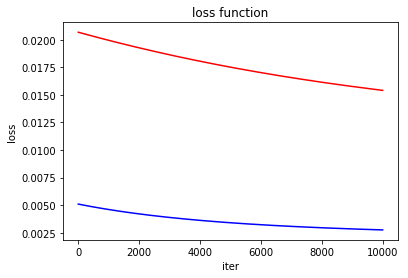

In [41]:
# パラメータの数値を調整
SLR_p1 = ScratchLogisticRegression(num_iter=10000, lr=0.001, C=0.01, plot=True)
SLR_p1.fit(X_train_std, y_train, X_val_std, y_val)

In [42]:
y_val_pred_sc1 = SLR_p1.predict(X_val_std)

In [43]:
# Accuracy(正解率)
from sklearn.metrics import accuracy_score
print("sklearnの正解率は{}です".format(accuracy_score(y_val, y_val_pred)))
print("スクラッチの正解率は{}です".format(accuracy_score(y_val, y_val_pred_sc1)))
# Precision(適合率)
from sklearn.metrics import precision_score
print("sklearnの適合率は{}です".format(precision_score(y_val, y_val_pred)))
print("スクラッチの適合率は{}です".format(precision_score(y_val, y_val_pred_sc1)))
# 混同行列
from sklearn.metrics import confusion_matrix
print("sklearnの混同行列は\n{}です".format(confusion_matrix(y_val, y_val_pred)))
print("スクラッチの混同行列は\n{}です".format(confusion_matrix(y_val, y_val_pred_sc1)))

sklearnの正解率は0.84です
スクラッチの正解率は0.84です
sklearnの適合率は0.9230769230769231です
スクラッチの適合率は0.9230769230769231です
sklearnの混同行列は
[[ 9  1]
 [ 3 12]]です
スクラッチの混同行列は
[[ 9  1]
 [ 3 12]]です


## 【問題6】学習曲線のプロット
学習曲線を見て損失が適切に下がっているかどうか確認してください。

実装済み

## 【問題7】決定領域の可視化
決定領域を可視化してください。

In [44]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)

    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

In [45]:
# 学習と推定:ロジスティック回帰(勾配降下法を使用)
from sklearn.linear_model import SGDClassifier
sgdc_model_2 = SGDClassifier(loss="log")
sgdc_model_2.fit(X_train[:, 2:], y_train)
y_val_pred_2 = sgdc_model_2.predict(X_val[:, 2:])
y_val_pred_2

/Users/arisa/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/arisa/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0])

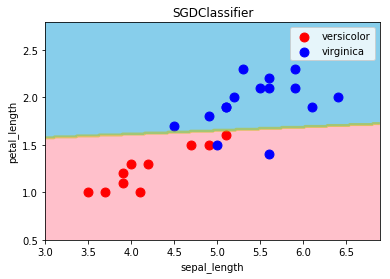

In [47]:
# 可視化
decision_region(X_val[:, 2:], np.ravel(y_val), sgdc_model_2, title="SGDClassifier", xlabel="sepal_length", ylabel="petal_length")

In [49]:
# ロジスティック回帰
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train[:, 2:], y_train)
y_pred_logistic_ns = clf.predict(X_val[:, 2:])
y_pred_logistic_ns

/Users/arisa/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0])

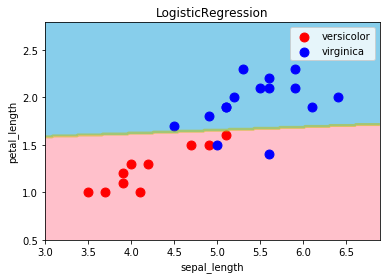

In [50]:
# 可視化
decision_region(X_val[:, 2:], np.ravel(y_val), clf, title="LogisticRegression", xlabel="sepal_length", ylabel="petal_length")

(75, 1)
loss: [0.04721796 0.04641726 0.04561698 ... 0.00562537 0.00562525 0.00562513]
val loss: [0.10187238 0.10010799 0.0983448  ... 0.01776163 0.01776136 0.0177611 ]


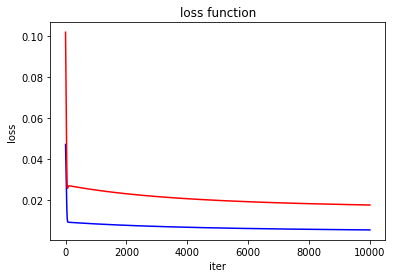

In [52]:
SLR_p2 = ScratchLogisticRegression(num_iter=10000, lr=0.01, C=0.01, plot=True)
SLR_p2.fit(X_train[:, 2:], y_train, X_val[:, 2:], y_val)

In [54]:
y_val_pred_sc2 = SLR_p2.predict(X_val[:, 2:])
y_val_pred_sc2.T

array([[1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 1, 0]])

In [55]:
y_val_pred_proba_sc2 = SLR_p2.predict_proba(X_val[:, 2:])
y_val_pred_proba_sc2.T

array([[0.60865113, 0.24766964, 0.43318488, 0.66574744, 0.86684641,
        0.11859693, 0.38115528, 0.83561969, 0.35906752, 0.8872437 ,
        0.68081787, 0.27932864, 0.56532387, 0.76657843, 0.68081787,
        0.2212599 , 0.13245441, 0.26678974, 0.78310562, 0.13988419,
        0.36636918, 0.61741169, 0.74423125, 0.788423  , 0.16791549]])

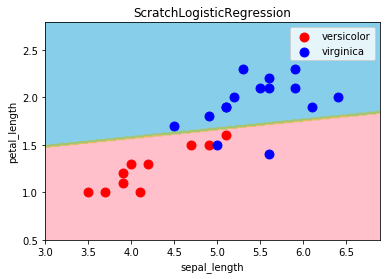

In [56]:
# 可視化
decision_region(X_val[:, 2:], np.ravel(y_val), SLR_p2, title="ScratchLogisticRegression", xlabel="sepal_length", ylabel="petal_length")

## 【問題8】（アドバンス課題）重みの保存
検証が容易になるように、学習した重みを保存および読み込みができるようにしましょう。pickleモジュールやNumPyのnp.savezを利用します。
pickle モジュールを利用するとオブジェクトをバイナリ形式でファイルに保存することができる

(75, 1)
loss: [0.04721796 0.04641726 0.04561698 ... 0.00562537 0.00562525 0.00562513]
val loss: [0.10187238 0.10010799 0.0983448  ... 0.01776163 0.01776136 0.0177611 ]


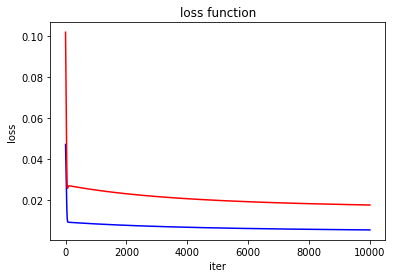

In [57]:
SLR_p3 = ScratchLogisticRegression(num_iter=10000, lr=0.01, C=0.01, plot=True)
SLR_p3.fit(X_train[:, 2:], y_train, X_val[:, 2:], y_val)

In [58]:
y_val_pred_proba_sc3 = SLR_p3.predict_proba(X_val[:, 2:])
y_val_pred_proba_sc3.T

array([[0.60865113, 0.24766964, 0.43318488, 0.66574744, 0.86684641,
        0.11859693, 0.38115528, 0.83561969, 0.35906752, 0.8872437 ,
        0.68081787, 0.27932864, 0.56532387, 0.76657843, 0.68081787,
        0.2212599 , 0.13245441, 0.26678974, 0.78310562, 0.13988419,
        0.36636918, 0.61741169, 0.74423125, 0.788423  , 0.16791549]])

In [59]:
import pickle
with open("model.pickle", mode="wb") as fp:
    pickle.dump(SLR_p3, fp)

In [60]:
with open('model.pickle', mode='rb') as fp:
    SLR_p4 = pickle.load(fp)

In [61]:
SLR_p4

In [63]:
# ダンプ解凍後のモデルでpred
SLR_p4.predict(X_val[:, 2:]).T

array([[1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 1, 0]])

In [64]:
# ダンプにする前のモデルでもpred
SLR_p3.predict(X_val[:, 2:]).T

array([[1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 1, 0]])

【考察】結果が同じとなった